# Find nights with Auxtel Spectra in OGA butler

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-11
- last update : 2024-01-14
- affiliation : IJCLab/IN2P3/CNRS


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [4]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T100936Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T130352Z


## Config

### Config collection

In [6]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21
my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"

### Config Auxtel

In [7]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [8]:
load_config(config_fullpath)

## Check the presence of the spectra

### select the date of observation

### Fitted param file output name

- Note each date is overwritted inside the hdf5 file

In [9]:
#fitted_paramfile = f"fitted_atmparamfile_{DATEOBS}.hdf5"
fitted_paramfile = "fitted_atmparamfile.hdf5"

## Access to spectra using the butler

In [10]:
#where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
where = "instrument='LATISS' "
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [11]:
print(">>> Number of records : ",len(records))
records[-1]

>>> Number of records :  3745


visit.RecordClass(instrument='LATISS', id=2023122000354, physical_filter='empty~holo4_003', name='AT_O_20231220_000354', day_obs=20231220, seq_num=354, exposure_time=60.0, target_name='HD38666', observation_reason='object', science_program='spec-survey', azimuth=253.24221978523886, zenith_angle=44.30329313452794, region=ConvexPolygon([UnitVector3d(0.05032420766700189, 0.8440678709139879, -0.5338697438640028), UnitVector3d(0.052411601044117184, 0.8441701745241088, -0.5335070201224422), UnitVector3d(0.052766587746899365, 0.8430535219112182, -0.5352349450574392), UnitVector3d(0.050679194338301994, 0.8429512183581443, -0.5355976687120105)]), timespan=Timespan(begin=astropy.time.Time('2023-12-21 08:01:17.426992', scale='tai', format='iso'), end=astropy.time.Time('2023-12-21 08:02:17.675000', scale='tai', format='iso')))

### List first of first records

       visit:
          instrument
          id
          physical_filter
          name: 'AT_O_20231220_000354'
         day_obs
         seq_num
         exposure_time
         target_name
         observation_reason
         science_program: 
         azimuth
         zenith_angle
         timespan

In [12]:
df_spec = pd.DataFrame(columns=['id',
                                'name',
                                'day_obs', 
                                'seq_num',
                                'time_start',
                                'time_end', 
                                'target',
                                'filter',
                                'exposure_time',
                                'azimuth',
                                'zenith',
                                'obs_reason',
                                'science_program',
                                'jd',
                                'mjd'])

In [13]:
for count, info in enumerate(registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection)):
       
    try:
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,pd.to_datetime(info.timespan.begin.to_string()),pd.to_datetime(info.timespan.end.to_string()) ,
                                  info.target_name, info.physical_filter, info.exposure_time, info.azimuth,info.zenith_angle, info.observation_reason, info.science_program,
                                  info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string) ,
                                  info.target_name, 
                                  info.physical_filter, info.exposure_time,info.azimuth,info.zenith_angle,
                                  info.zenith_angle,  info.observation_reason, info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd  ]
 

In [14]:
df_spec

,id,name,day_obs,seq_num,time_start,time_end,target,filter,exposure_time,azimuth,zenith,obs_reason,science_program,jd,mjd
0,2022091300503,AT_O_20220913_000503,20220913,503,2022-09-14 04:31:53.075991,2022-09-14 04:32:23.315,HD200654,empty~holo4_003,30.0,222.040262,31.590857,object,unknown,2.459837e+06,59836.188809
1,2022091300504,AT_O_20220913_000504,20220913,504,2022-09-14 04:32:35.970991,2022-09-14 04:33:06.208,HD200654,empty~holo4_003,30.0,222.135995,31.694993,object,unknown,2.459837e+06,59836.189305
2,2022091300510,AT_O_20220913_000510,20220913,510,2022-09-14 04:36:06.316983,2022-09-14 04:36:36.547,HD167060,empty~holo4_003,30.0,213.071886,57.214064,object,unknown,2.459837e+06,59836.191740
3,2022091300511,AT_O_20220913_000511,20220913,511,2022-09-14 04:36:49.162013,2022-09-14 04:37:19.391,HD167060,empty~holo4_003,30.0,213.064771,57.296880,object,unknown,2.459837e+06,59836.192236
4,2022091300517,AT_O_20220913_000517,20220913,517,2022-09-14 04:40:45.594004,2022-09-14 04:41:15.829,HD14943,empty~holo4_003,30.0,135.396120,38.173988,object,unknown,2.459837e+06,59836.194972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,2023122000326,AT_O_20231220_000326,20231220,326,2023-12-21 07:21:53.394995,2023-12-21 07:22:53.633,HD38666,empty~holo4_003,60.0,255.500938,36.087469,object,spec-survey,2.460300e+06,60299.306868
3741,2023122000327,AT_O_20231220_000327,20231220,327,2023-12-21 07:23:06.315984,2023-12-21 07:24:06.548,HD38666,empty~holo4_003,60.0,255.437567,36.342375,object,spec-survey,2.460300e+06,60299.307712
3742,2023122000340,AT_O_20231220_000340,20231220,340,2023-12-21 07:42:15.500014,2023-12-21 07:43:15.741,HD38666,empty~holo4_003,60.0,254.385277,40.345853,object,spec-survey,2.460300e+06,60299.321013
3743,2023122000341,AT_O_20231220_000341,20231220,341,2023-12-21 07:43:28.600000,2023-12-21 07:44:28.835,HD38666,empty~holo4_003,60.0,254.314880,40.599537,object,spec-survey,2.460300e+06,60299.321859


In [15]:
df_spec["year"] = df_spec["day_obs"].apply(lambda x : x//10_000)
df_spec["yearmonth"] = df_spec["day_obs"].apply(lambda x : x//100)
df_spec["time"] = pd.to_datetime(df_spec['time_start'])

In [16]:
df_spec["day_obs"].unique()

array([20220913, 20220914, 20220927, 20220928, 20220929, 20221011,
       20221012, 20221025, 20221026, 20221027, 20221109, 20221110,
       20221123, 20221207, 20221208, 20221209, 20221210, 20221212,
       20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
       20230314, 20230315, 20230316, 20230509, 20230510, 20230511,
       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
       20231108, 20231113, 20231114, 20231115, 20231116, 20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220])

### Time series

In [17]:
df_spec_visit = df_spec.groupby(['day_obs']).count()["id"]
df_spec_visit.name = "countVisitperBandperNight" 
df_spec_visit

day_obs
20220913    106
20220914    176
20220927     76
20220928     98
20220929     98
           ... 
20231212     21
20231214     40
20231215     19
20231219     21
20231220     34
Name: countVisitperBandperNight, Length: 74, dtype: int64

Text(0.5, 1.0, 'Auxtel Spectro Year 2022 and 2023 nspec = 3745 ndays = 74 (/repo/embargo)')

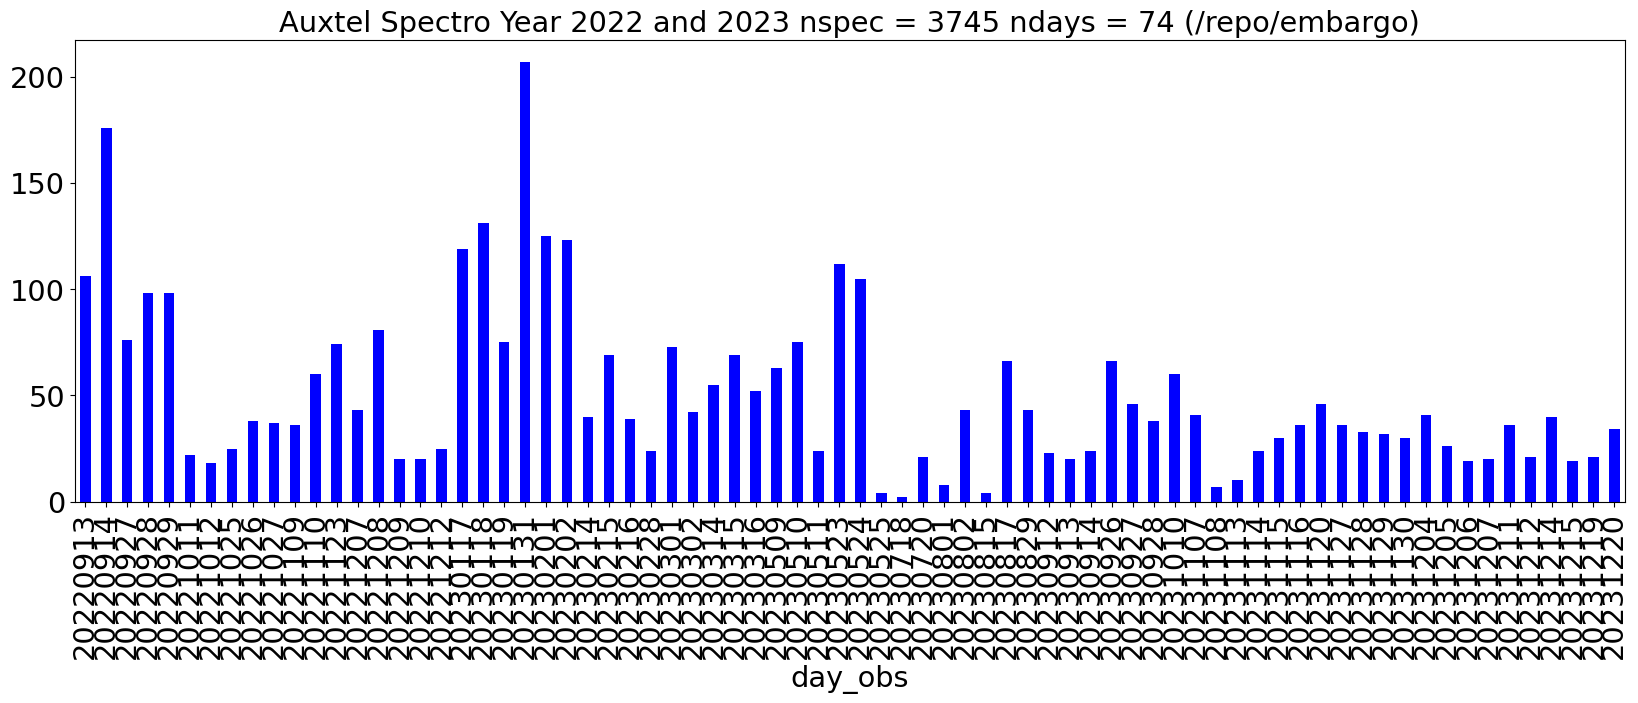

In [18]:
nspec = df_spec_visit.sum()
ndays = df_spec_visit.count()
suptitle = f"Auxtel Spectro Year 2022 and 2023 nspec = {nspec} ndays = {ndays} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_spec_visit.plot(x='day_obs',kind="bar",facecolor="b",ax=ax)
ax.set_title(suptitle)

Text(0.5, 0, 'year,month,day')

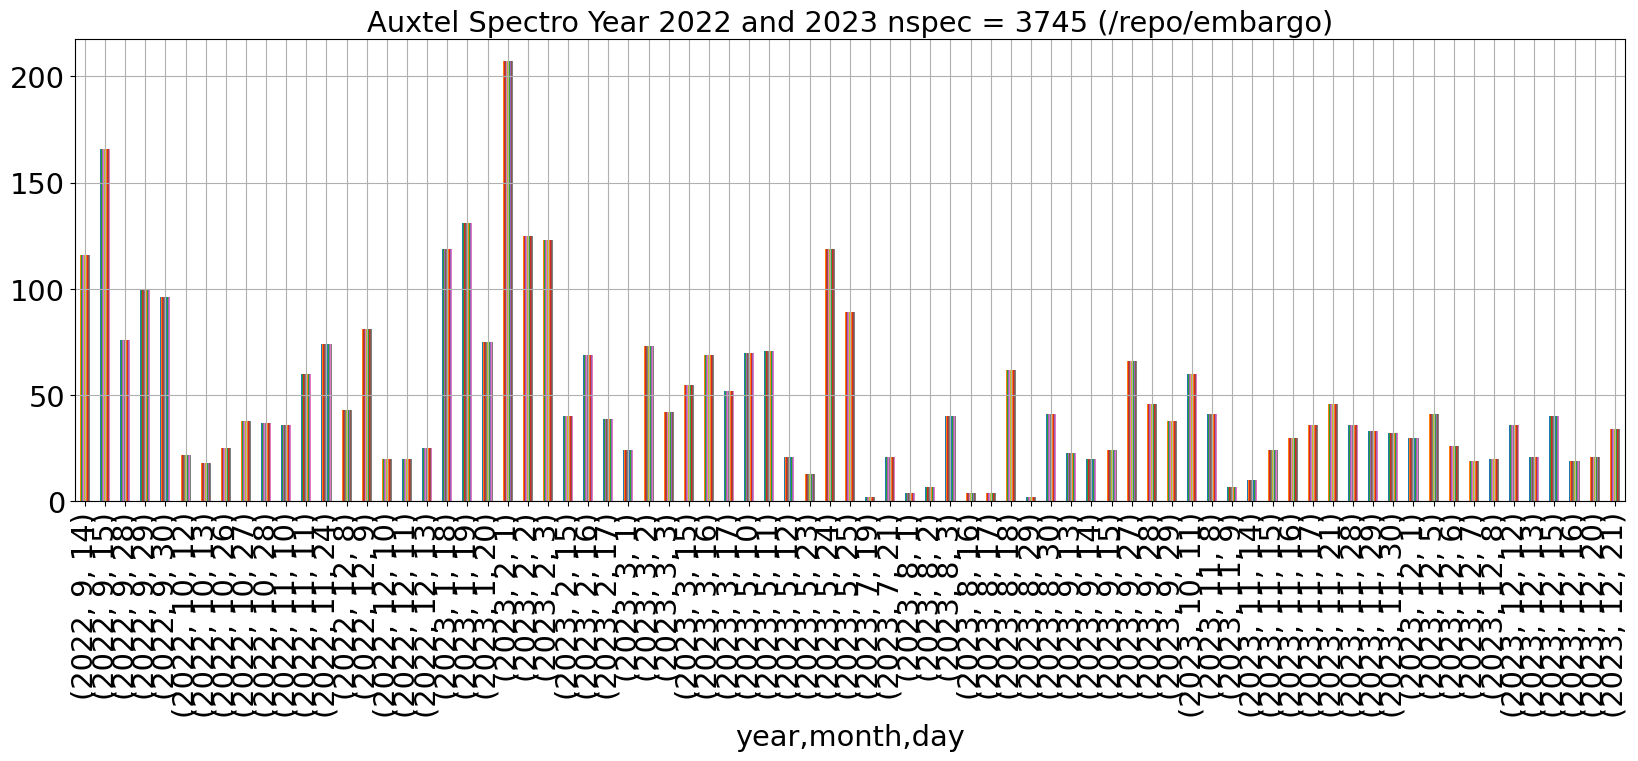

In [19]:
nspec = df_spec.id.count()
suptitle = f"Auxtel Spectro Year 2022 and 2023 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_spec.groupby([df_spec["time"].dt.year, df_spec["time"].dt.month,df_spec["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

## Save the 

In [ ]:
df_spec_visit.to_csv("spec_series_repo_embargo.csv")

## Compare 2022 and 2023

In [20]:
df_2022 = df_spec[df_spec.year == 2022]
df_2023 = df_spec[df_spec.year == 2023]

### Year 2022

In [21]:
df_2022["day_obs"].unique()

array([20220913, 20220914, 20220927, 20220928, 20220929, 20221011,
       20221012, 20221025, 20221026, 20221027, 20221109, 20221110,
       20221123, 20221207, 20221208, 20221209, 20221210, 20221212])

### Year 2023

In [22]:
df_2023["day_obs"].unique()

array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
       20230314, 20230315, 20230316, 20230509, 20230510, 20230511,
       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
       20231108, 20231113, 20231114, 20231115, 20231116, 20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220])

In [23]:
df_spec["filter"].unique()

array(['empty~holo4_003', 'OG550_65mm_1~holo4_003'], dtype=object)

In [24]:
df_spec.target.unique()

array(['HD200654', 'HD167060', 'HD14943', 'HD031128', 'MU-COL', 'HD37962',
       'HD38949', 'HD185975', 'HD205905', 'HD2811', 'HD009051',
       'ETA1-DOR', 'HD60753', 'HD074000', 'HD111980', 'HD115169',
       'HD 38949', 'HD 38666', 'HD 42525', 'HD38666', 'HD42525',
       'HD142331', 'HD146233', 'Feige110', 'HD160617'], dtype=object)

In [25]:
df_spec.science_program.unique()

array(['unknown', 'spec', 'SITCOM-621', 'SITCOM-1001', 'SITCOM-1022',
       'BLOCK-102', 'spec-survey'], dtype=object)

In [26]:
df_spec.obs_reason.unique()

array(['object', 'generic', 'crowded', 'sitcom-1043', 'y_offset_-100'],
      dtype=object)

## Plot Year 2022

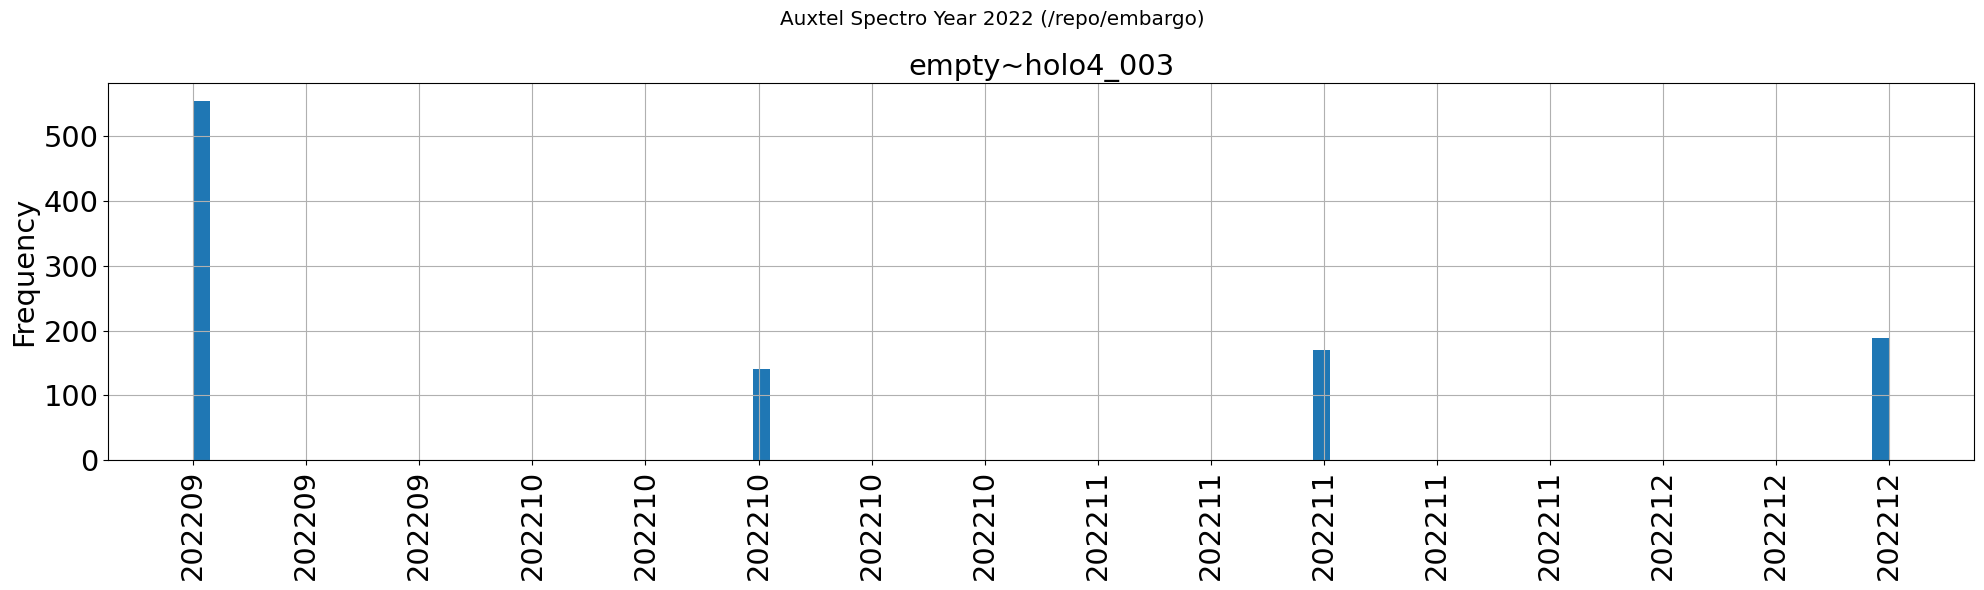

In [27]:
suptitle = "Auxtel Spectro Year 2022 (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2022.plot.hist(column=["yearmonth"] ,by="filter",bins=100,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [28]:
df_2022.id.count()

1053

Text(0.5, 0, 'year,month,day')

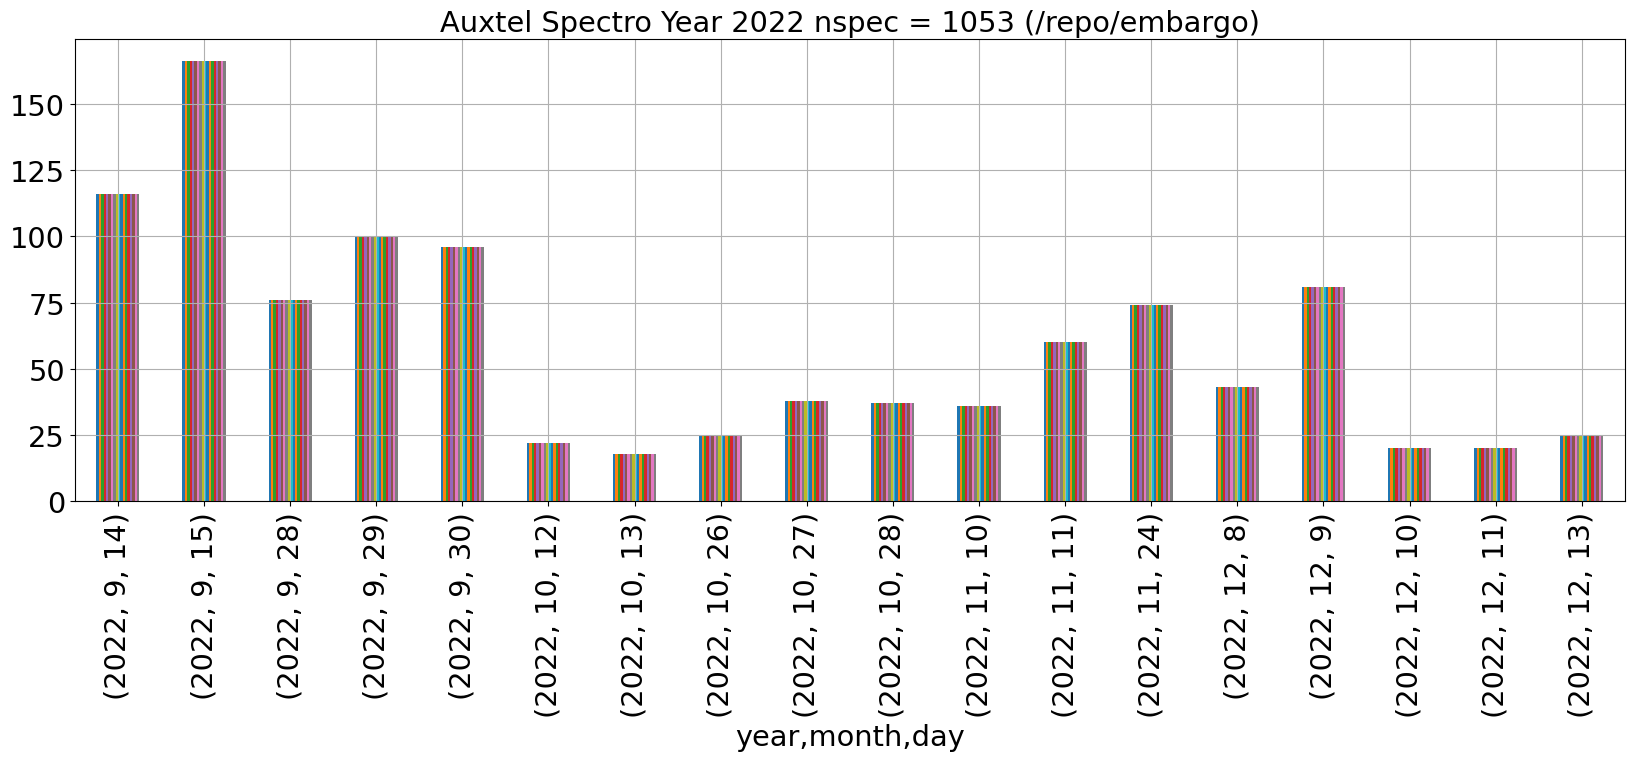

In [29]:
nspec = df_2022.id.count()
suptitle = f"Auxtel Spectro Year 2022 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2022.groupby([df_2022["time"].dt.year, df_2022["time"].dt.month,df_2022["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

### Plot Year 2023

/tmp/ipykernel_33260/1995832163.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_2023.plot.hist(column=["day_obs"] ,by="filter",bins=365,grid=True,ax=ax,legend=False)


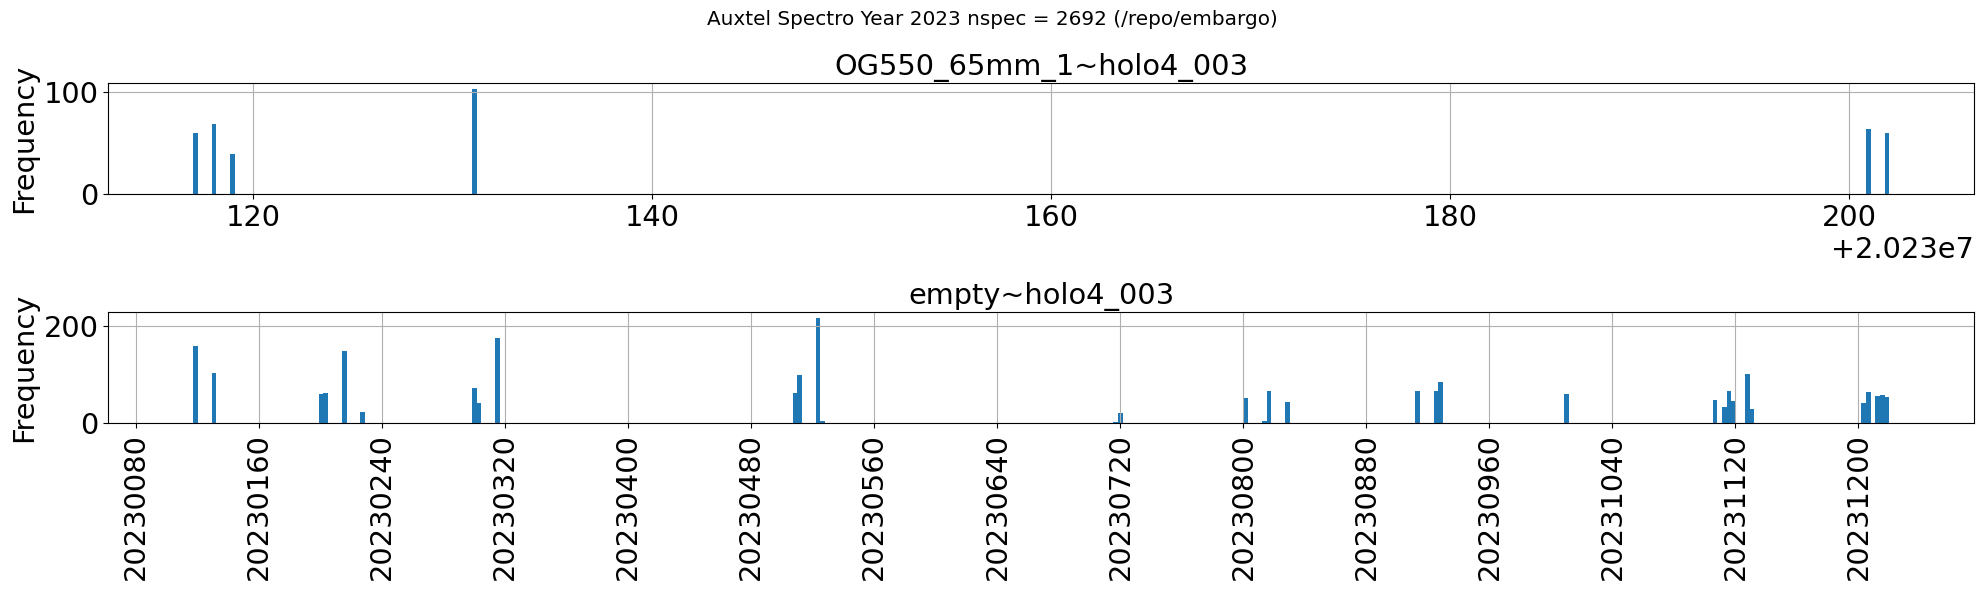

In [30]:
nspec = df_2023.id.count()
suptitle = f"Auxtel Spectro Year 2023 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2023.plot.hist(column=["day_obs"] ,by="filter",bins=365,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

Text(0.5, 0, 'year,month,day')

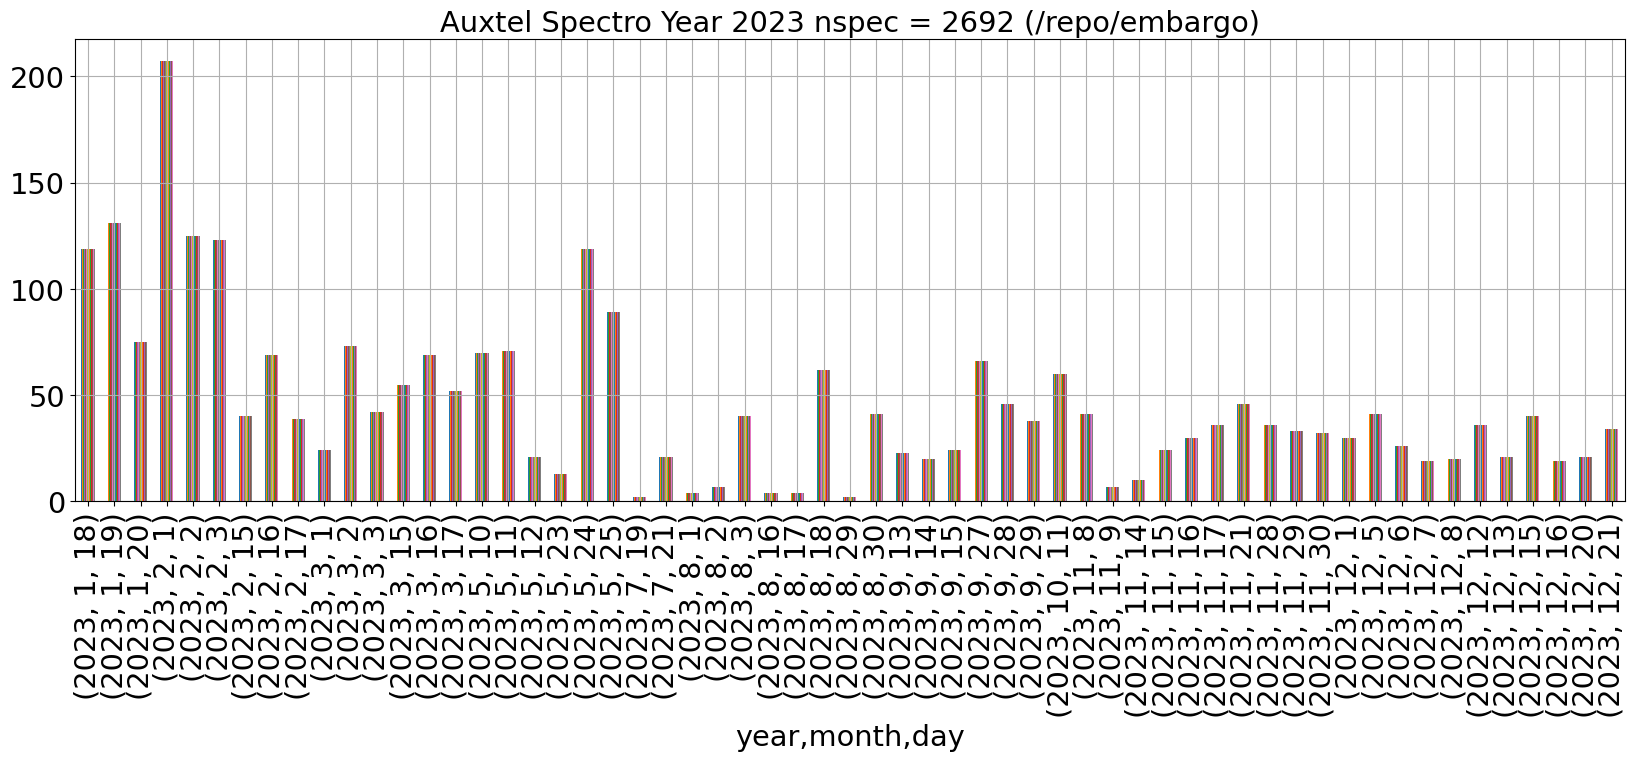

In [31]:
nspec = df_2023.id.count()
suptitle = f"Auxtel Spectro Year 2023 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2023.groupby([df_2023["time"].dt.year, df_2023["time"].dt.month,df_2023["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

# Visits

In [66]:
df_spec_visit.cumsum()

day_obs
20220913     106
20220914     282
20220927     358
20220928     456
20220929     554
            ... 
20231212    3631
20231214    3671
20231215    3690
20231219    3711
20231220    3745
Name: countVisitperBandperNight, Length: 74, dtype: int64

In [48]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [55]:
dt = [ convertNumToDatestr(num) for num in df_spec_visit.index ]

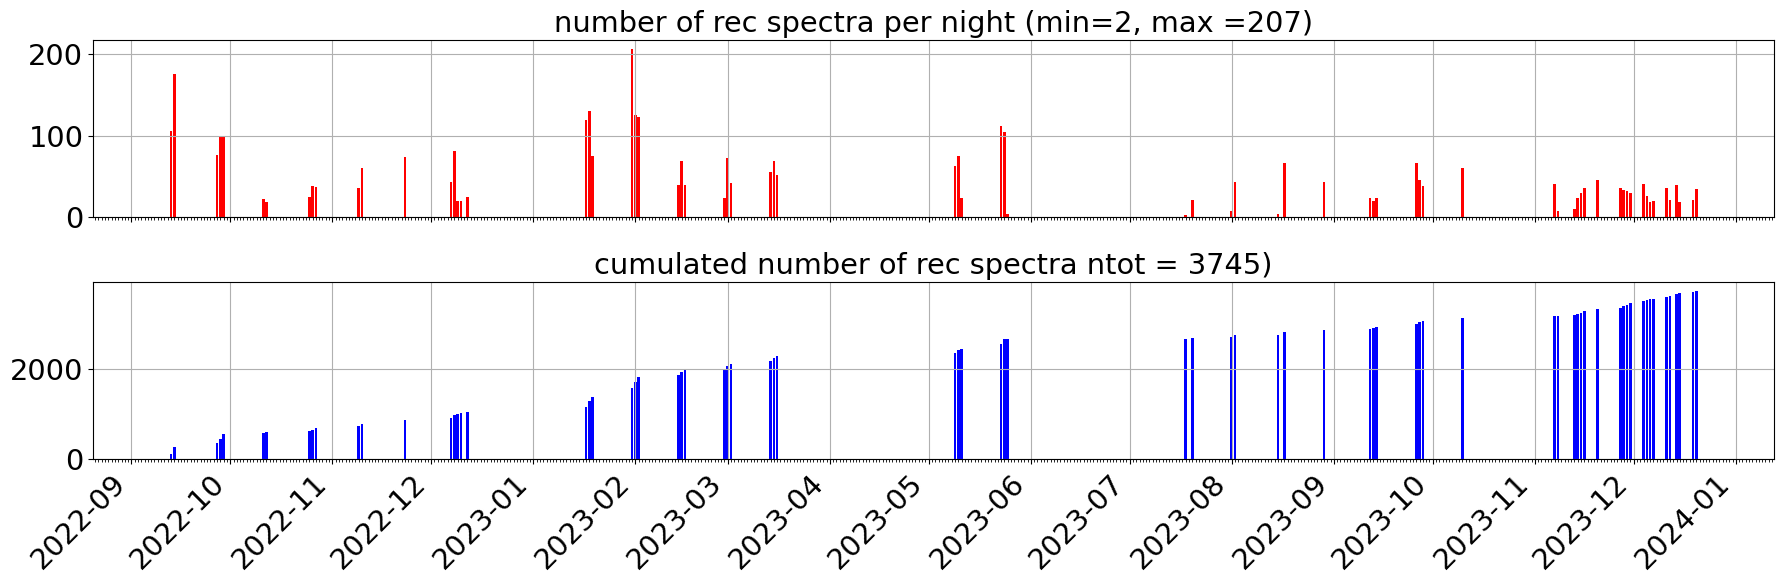

In [82]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18, 6),sharex=True)


# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt,df_spec_visit.values,lw=5,facecolor='r')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

minnspec= df_spec_visit.min()
maxnspec= df_spec_visit.max()
totnspec= df_spec_visit.sum()
title1 = f"number of rec spectra per night (min={minnspec}, max ={maxnspec})"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"cumulated number of rec spectra ntot = {totnspec})"
ax2.set_title(title2)

plt.tight_layout()